# 0 Begin chapter

## 0.1. install

In [7]:
!python -m pip install pandas pyarrow nltk ratelimit


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 0.2. Import

In [1]:
import pandas as pd
import numpy as np
import sys
import json
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from ratelimit import limits
from config import api_key_mapquests
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

from IPython.display import clear_output
from tqdm.notebook import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

nltk.downloader.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\f999145\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\f999145\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\f999145\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
sys.version
# '3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]'

'3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]'

## 0.3. load data

In [146]:
hotels = pd.read_csv('data/hotels.zip')
# hotels.to_parquet('data/hotels_parquet.gzip', engine='pyarrow', compression='gzip')
hotels = hotels.convert_dtypes()
hotels.info()

## 0.4. INFO
---
- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.
---

# 1 Исследование данных

## 1.1. Отделение Категориальных признаков

Я разделю признаки по количеству уникальных значений.

До 20% будут категориальные признаки, остальные - остальные.

In [8]:
resolution = hotels.shape[0]
tmp_cols = (
            hotels
            .nunique()
            .sort_values(ascending=False)
            .to_frame(name='count')
            .assign(frec=lambda x: round(100*x['count']/resolution).astype('UInt8'))
            )

cat_cols = (
            tmp_cols
            .query('frec < 20')
            .index
            .to_list()
            )

other_cols = (
                tmp_cols
                .query('frec >= 20')
                .index
                .to_list()
                )

print(f'cat_cols: {len(cat_cols)}; other_cols: {len(other_cols)}')


cat_cols: 15; other_cols: 2


## 1.2. Преобразование Категориальных признаков

### 1.2.1. Преобразование типов `"object"` или `"string"`

Выделяем только интерисующие нас признаки.

In [9]:
object_cols = hotels[cat_cols].select_dtypes(include='string').columns.to_list()
# other_cat_cols = [x for x in cat_cols if x not in object_cols]
other_cat_cols = list(filter(lambda x: x not in object_cols, cat_cols))

hotels[object_cols].head()

,tags,hotel_address,hotel_name,days_since_review,review_date,reviewer_nationality
0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",Stratton Street Mayfair Westminster Borough Lo...,The May Fair Hotel,531 day,2/19/2016,United Kingdom
1,"[' Business trip ', ' Couple ', ' Standard Dou...",130 134 Southampton Row Camden London WC1B 5AF...,Mercure London Bloomsbury Hotel,203 day,1/12/2017,United Kingdom
2,"[' Leisure trip ', ' Solo traveler ', ' Modern...",151 bis Rue de Rennes 6th arr 75006 Paris France,Legend Saint Germain by Elegancia,289 day,10/18/2016,China
3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,Mercure Paris 19 Philharmonie La Villette,681 day,9/22/2015,United Kingdom
4,"[' Business trip ', ' Couple ', ' Standard Dou...",Molenwerf 1 1014 AG Amsterdam Netherlands,Golden Tulip Amsterdam West,516 day,3/5/2016,Poland


In [10]:
# Преобразование столбца "tags"
hotels['tags'] = hotels['tags'].str.replace('\'','\"' ).apply(lambda x: json.loads(x))

# Преобразование признака "days_since_review"
hotels['days_since_review'] = hotels['days_since_review'].str.extract('(\d+) day', expand=False).astype('UInt16')

# Преобразование признака "review_date"
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Преобразование признака "reviewer_nationality"
hotels['hotel_name'] = hotels['hotel_name'].str.strip().replace('', pd.NA)
category_order_list = sorted([x for x in hotels['hotel_name'].unique() if not pd.isnull(x)])
hotels['hotel_name'] = hotels['hotel_name'].astype('category').cat.set_categories(category_order_list, ordered=True)

# Преобразование признака "reviewer_nationality"
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.strip().replace('', pd.NA)
category_order_list = sorted([x for x in hotels['reviewer_nationality'].unique() if not pd.isnull(x)])
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].astype('category').cat.set_categories(category_order_list, ordered=True)

# Преобразование признака "hotel_address"
hotels['hotel_address'] = hotels['hotel_address'].astype('string')

### 1.2.2. Преобразование типов других типов

In [11]:
hotels[other_cat_cols].head()

,lat,lng,total_number_of_reviews,additional_number_of_scoring,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,average_score
0,51.507894,-0.143671,1994,581,3,4,7,10.0,8.4
1,51.521009,-0.123097,1361,299,3,2,14,6.3,8.3
2,48.845377,2.325643,406,32,6,0,14,7.5,8.9
3,48.888697,2.39454,607,34,0,11,8,10.0,7.5
4,52.385601,4.84706,7586,914,4,20,10,9.6,8.5


In [12]:
hotels['lat'] = hotels['lat'].astype('Float32')
hotels['lng'] = hotels['lng'].astype('Float32')
hotels['total_number_of_reviews'] = hotels['total_number_of_reviews'].astype('UInt16')
hotels['additional_number_of_scoring'] = hotels['additional_number_of_scoring'].astype('UInt16')
hotels['review_total_negative_word_counts'] = hotels['review_total_negative_word_counts'].astype('UInt16')
hotels['review_total_positive_word_counts'] = hotels['review_total_positive_word_counts'].astype('UInt16')
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].astype('UInt16')
hotels['reviewer_score'] = hotels['reviewer_score'].astype('Float32')
hotels['average_score'] = hotels['average_score'].astype('Float32')
hotels['negative_review'] = hotels['negative_review'].astype('string').str.strip().str.lower()
hotels['positive_review'] = hotels['positive_review'].astype('string').str.strip().str.lower()

### 1.2.3. Точка сохранения

In [31]:
# hotels.to_parquet('data/hotels.gzip', engine='pyarrow', compression='gzip')

### 1.2.3. Работа с отзывами.

In [ ]:
hotels = pd.read_parquet('data/hotels.gzip')

In [54]:
hotels = hotels.replace({'positive_review':{'':pd.NA}, 'negative_review':{'':pd.NA}})

#### 1.2.3.1. Поиск Вредных данных

In [58]:
# Закоментирован код, с помощью которого происходи поиск значений
# with pd.option_context("display.max_columns", 500, "display.max_rows", 500, "display.max_colwidth", 1000):
#     display((hotels[hotels['positive_review']
#                     # Поиск элементов
#                     # .str.match(r'\b(no[^r]).*\b')]['positive_review']
#                     .str.match(r'\b(n\s?a).*\b')]['positive_review']
#                     .value_counts()
#                     .reset_index()
#                     .query('count > 1')
#                     .head(500)))
    

# Вредные элементы
list_positive_of_fault = """
no positive
none
non
n a
na
no
""".strip().split('\n')

In [59]:
# Закоментирован код, с помощью которого происходи поиск значений
# with pd.option_context("display.max_columns", 500, "display.max_rows", 500, "display.max_colwidth", 1000):
#     display((hotels
#             #  [hotels['negative_review']
#             #         # Поиск элементов
#             #         # .str.match(r'\b(no[^r]).*\b')]['negative_review']
#             #         .str.match(r'\b(n\s?a).*\b')]
#                     ['negative_review']
#                     .value_counts()
#                     .reset_index()
#                     .query('count > 1')
#                     .head(500)))
    

# Вредные элементы
list_negativ_of_fault = """
no negative
none
non
n a
all good
na
no
nil
no faults
good
""".strip().split('\n')

#### 1.2.3.2. Удаление Вредных данных

In [60]:
hotels = hotels.replace({'positive_review':dict(zip(list_positive_of_fault, [pd.NA]*len(list_positive_of_fault))),
                            'negative_review':dict(zip(list_negativ_of_fault, [pd.NA]*len(list_negativ_of_fault)))
                            })

#### 1.2.3.3. Взвешивание отзывов

In [114]:
sent_analyzer = SentimentIntensityAnalyzer()

def get_sentiment(row:str, col_name:list|tuple|None=None) -> pd.Series:
    
    if not pd.isnull(row):
        if col_name and len(col_name) == 4:
            return pd.Series(sent_analyzer.polarity_scores(row).values(), index=col_name)
        else:
            return pd.Series(sent_analyzer.polarity_scores(row).values())
    else:
        if col_name and len(col_name) == 4:
            return pd.Series(pd.NA, index=col_name)
        else:
            return pd.Series(pd.NA)


hotels = pd.concat((hotels, hotels['positive_review'].progress_apply(get_sentiment, args=(('pos_neg', 'pos_neu', 'pos_pos', 'pos_compound'),)).astype('Float32')), axis=1)
hotels = pd.concat((hotels, hotels['negative_review'].progress_apply(get_sentiment, args=(('neg_neg', 'neg_neu', 'neg_pos', 'neg_compound'),)).astype('Float32')), axis=1)

  0%|          | 0/386803 [00:00<?, ?it/s]

  0%|          | 0/386803 [00:00<?, ?it/s]

#### 1.2.3.4. Считаем количество слов.

In [122]:
# Удаление пунктуации
def remove_punctuation(text: str):
    import pandas as pd
    if not pd.isnull(text):
        import string
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)
    else:
        return pd.NA

# Убираем стом слова
def remove_stopwords(text: str):
    import pandas as pd
    if not pd.isnull(text):
        from nltk.corpus import stopwords
        from nltk.tokenize import word_tokenize
        
        text = text.lower()
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_text)
    else:
        return pd.NA

# Нормализуем окончания
def normalize_endings(text: str):
    import pandas as pd
    if not pd.isnull(text):
        from nltk.tokenize import word_tokenize
        from nltk.stem import SnowballStemmer
        
        stemmer = SnowballStemmer('english')
        tokens = word_tokenize(text)
        normalized_text = [stemmer.stem(word) for word in tokens]
        return ' '.join(normalized_text)
    else:
        return pd.NA


hotels['negative_review'] = hotels['negative_review'].progress_apply(remove_punctuation)
clear_output()

hotels['negative_review'] = hotels['negative_review'].parallel_apply(remove_stopwords)
clear_output()

hotels['negative_review'] = hotels['negative_review'].parallel_apply(normalize_endings)
clear_output()

hotels['positive_review'] = hotels['positive_review'].progress_apply(remove_punctuation)
clear_output()

hotels['positive_review'] = hotels['positive_review'].parallel_apply(remove_stopwords)
clear_output()

hotels['positive_review'] = hotels['positive_review'].parallel_apply(normalize_endings)
clear_output()

hotels['pos_word_count'] = hotels['positive_review'].str.split().str.len()
hotels['neg_word_count'] = hotels['negative_review'].str.split().str.len()
hotels = hotels.drop(columns=['positive_review','negative_review'])

#### 1.2.3.4. Точка сохранения.

In [126]:
# hotels.to_parquet('data/hotels.gzip', engine='pyarrow', compression='gzip')

### 1.2.4. Работа с признаком "Tags"

In [ ]:
hotels = pd.read_parquet('data/hotels.gzip')

In [134]:
tags_unique_list = dict(zip(a:=(
                            hotels['tags']
                            .explode()
                            .str.strip()
                            # .unique()
                            .value_counts()
                            .to_frame()
                            .assign(count=lambda x: x['count']/hotels.shape[0])
                            .query('count > 0.1') # Оставляем только те признаки, которые присутствубт более чем в 10% раз.
                            .index
                            ),
                            [False]*len(a)
                            ))


 
def get_dummis_table(row: pd.Series, tags_unique_list: dict):
    """
    
    """
    import pandas as pd
    tmp_dict =tags_unique_list.copy()
    for item in list(map(lambda x: x.strip(), row)):
        if item in tmp_dict.keys():
            tmp_dict[item] = True
    return pd.Series(tmp_dict)


hotels = pd.concat((hotels, hotels['tags'].parallel_apply(get_dummis_table, args=(tags_unique_list,))), axis=1).drop(columns='tags')
clear_output()
hotels.shape


(386803, 35)

#### 1.2.4.1. Точка сохранения.

In [181]:
# hotels.to_parquet('data/hotels.gzip', engine='pyarrow', compression='gzip')

### 1.2.5. Работа с адресами.

In [ ]:
hotels = pd.read_parquet('data/hotels.gzip')

#### 1.2.5.1 Количество пропусков в признаках "lat" и "lgn"

In [185]:
with pd.option_context("display.max_columns", 500, "display.max_rows", 500, "display.max_colwidth", 1000):
    print('Было:')
    print('Количество пропусков:', (hotels['lat'].isnull() | hotels['lng'].isnull()).sum())
    display(hotels[['hotel_address', 'lat', 'lng']].iloc[121:123])

Было:
Количество пропусков: 2448


,hotel_address,lat,lng
121,225 High Street Kensington Kensington and Chelsea London W8 6SA United Kingdom,51.499279,-0.197359
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,<NA>,<NA>


#### 1.2.5.2. Заполнение пропусков, путем поиска координат через библиотеку.

In [186]:
def _get_json_address(col_value: str, api_key: str) -> str:
    import requests
    import numpy as np
    import pandas as pd
    url = 'https://www.mapquestapi.com/geocoding/v1/address'
    params = {
        'key': api_key,
        'location': col_value,
    }
    
    try:
        res = requests.get(url=url, params=params)
    except TimeoutError:
        return pd.Series(pd.NA)
    except requests.ConnectTimeout:
        return pd.Series(pd.NA)
    
    tmp = res.json()
    
    latLng = tmp.get('results', [{}])[0].get('locations', [{}])[0].get('latLng', pd.NA)
        
    return pd.Series(latLng)

In [187]:
latLng_index = (hotels['lat'].isnull() | hotels['lng'].isnull()).to_frame('b').query('b == True').index
hotels.loc[latLng_index, ['lat', 'lng']] = hotels.loc[latLng_index, 'hotel_address'].parallel_apply(_get_json_address, args=(api_key_mapquests,))
clear_output()
with pd.option_context("display.max_columns", 500, "display.max_rows", 500, "display.max_colwidth", 1000):
    print('Стало:')
    print('Количество пропусков', (hotels['lat'].isnull() | hotels['lng'].isnull()).sum())
    display(hotels[['hotel_address', 'lat', 'lng']].iloc[121:123])

Стало:
Количество пропусков 0


,hotel_address,lat,lng
121,225 High Street Kensington Kensington and Chelsea London W8 6SA United Kingdom,51.499279,-0.197359
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,48.22023,16.285101


In [190]:
hotels = hotels.drop(columns='hotel_address')

#### 1.2.5.3. Точка сохранения.

In [192]:
# hotels.to_parquet('data/hotels.gzip', engine='pyarrow', compression='gzip')

# 2. Подготовка данных для модели

In [51]:
hotels = pd.read_parquet('data/hotels.gzip')

## 2.1. Преобразование Признаков с датой и удаление не числовых признаков.

In [197]:
hotels['review_date_from_2015-01-01'] = (hotels['review_date'] - pd.to_datetime('2015-01-01')).dt.days.astype('UInt16')
drop_col_list = list(hotels.select_dtypes('object').columns)
drop_col_list.extend(list(hotels.select_dtypes('string').columns))
drop_col_list.extend(list(hotels.select_dtypes('datetime64[ns]').columns))

hotels = hotels.drop(columns=drop_col_list)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                386803 non-null  UInt16  
 1   average_score                               386803 non-null  Float32 
 2   hotel_name                                  386803 non-null  category
 3   reviewer_nationality                        386408 non-null  category
 4   review_total_negative_word_counts           386803 non-null  UInt16  
 5   total_number_of_reviews                     386803 non-null  UInt16  
 6   review_total_positive_word_counts           386803 non-null  UInt16  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  UInt16  
 8   reviewer_score                              386803 non-null  Float32 
 9   days_since_review                           386803 non-null

## 2.2. Преобразование Категориальных признаков в числовые, и заполнение пропусков Нулевым значением.

In [200]:
for col in hotels.select_dtypes('category').columns:
    hotels[col] = (hotels[col].cat.codes + 1).fillna(0)

hotels = hotels.fillna(0)
hotels.isnull().sum().sum()

0

## 2.3. Удаление признаков с сильной корреляцией.

### 2.3.1. Построение графика корреляции

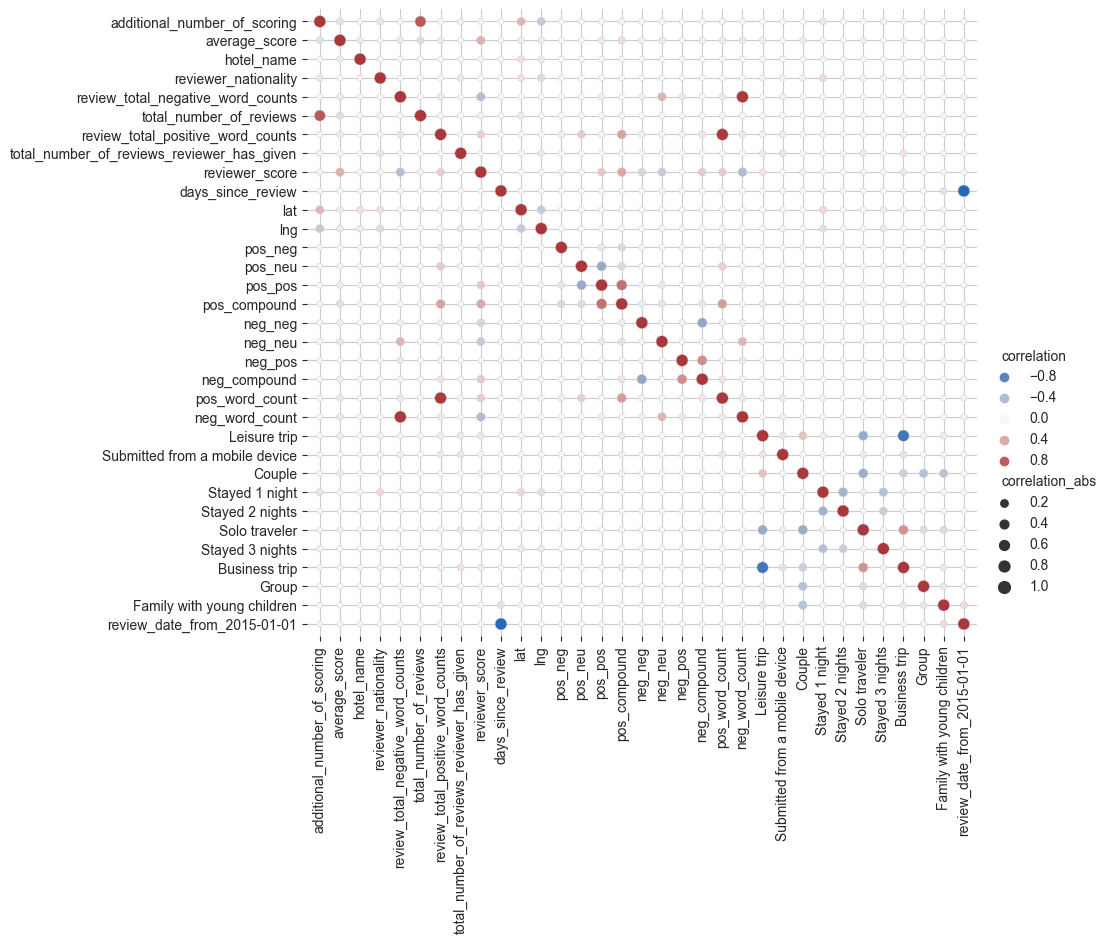

In [202]:
corr_mat = hotels.corr().stack().reset_index(name="correlation")
corr_mat['correlation_abs'] = corr_mat['correlation'].abs()
sns.set_style("ticks",{'axes.grid' : True})
g = sns.relplot(
                data=corr_mat,
                x="level_0",
                y="level_1",
                hue="correlation",
                size="correlation_abs",
                height=7,
                aspect=1.5,
                palette="vlag",
                edgecolor=".8",
                # sizes=(50, 250),
                # size_norm=(-.2, .8),
                # dashes=True
                )
g.set(xlabel="", ylabel="")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

### 2.3.2. Признаки с корреляцией выше 70%

In [205]:
corr_mat.query('(correlation_abs > 0.7) & (level_0 != level_1)')

,level_0,level_1,correlation,correlation_abs
5,additional_number_of_scoring,total_number_of_reviews,0.824467,0.824467
153,review_total_negative_word_counts,neg_word_count,0.989026,0.989026
165,total_number_of_reviews,additional_number_of_scoring,0.824467,0.824467
218,review_total_positive_word_counts,pos_word_count,0.981529,0.981529
329,days_since_review,review_date_from_2015-01-01,-1.000000,1.000000
477,pos_pos,pos_compound,0.700818,0.700818
509,pos_compound,pos_pos,0.700818,0.700818
666,pos_word_count,review_total_positive_word_counts,0.981529,0.981529
697,neg_word_count,review_total_negative_word_counts,0.989026,0.989026
755,Leisure trip,Business trip,-0.904145,0.904145


### 2.3.3. Разбитие пар признаков с сильной корреляцией и удаление одной из пар

In [233]:
corr_dict = dict((corr_mat.query('(correlation_abs > 0.7) & (level_0 != level_1)')[['level_0', 'level_1']].to_dict('split')).get('data'))
vals_1, vals_2 = [], []
for col_1, col_2 in corr_dict.items():
    vals_2.append(col_2)
    if not col_1 in vals_2:
        vals_1.append(col_1)

hotels = hotels.drop(columns=vals_1)


### 2.4. Точка сохранения.

In [235]:
# hotels.to_parquet('data/hotels_2.4.gzip', engine='pyarrow', compression='gzip')

## 3. Вычисление MAPE

In [2]:
hotels = pd.read_parquet('data/hotels_2.4.gzip')

In [3]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [4]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [6]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.123881267400766


<AxesSubplot: >

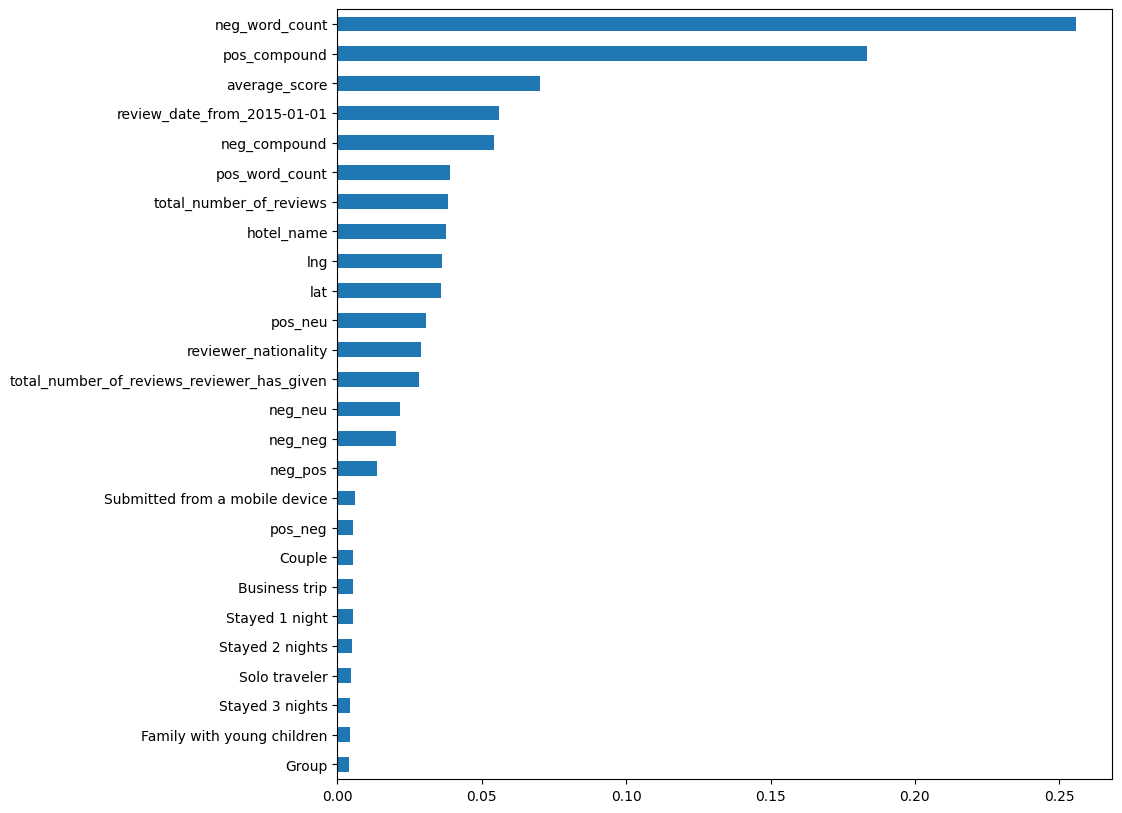

In [10]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')



In [29]:
test = hotels.copy()
test_col = list(feat_importances.to_frame('feature_importances').query('feature_importances > 0.01').index)
test_col.append('reviewer_score')
test = test[test_col]

In [30]:
X = test.drop(['reviewer_score'], axis = 1)  
y = test['reviewer_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
regr = RandomForestRegressor(n_estimators=100)  
regr.fit(X_train, y_train)  
y_pred = regr.predict(X_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12420460884241749


# Result:

В данной работе были проведены следующие действия:
1. Работа с признаками
   1. Преобразование признаков
   2. Очистка признаков (positive_review, negative_review)
   3. Создание новых признаков 
      1. по признаку tags
      2. взвешивание positive_review, negative_review
      3. количество слов в positive_review, negative_review
   4. Заполнение пропусков данных в признаках "lat" и "lgn"
2. Подготовили данные к модели.
   1. Заполнили пропуски нулями
   2. Удалили коррелирующие признаки
3. Вычислили MAPE 12.39%


Если удалить менее важные признаки MAPE = 12.42%